In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import DataLoader
import os
from cust_model import Tracker, TrackingDataset
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
from import_data import grab_amazon_data
inputs_prebatch, outputs_prebatch = grab_amazon_data()

1


In [4]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict({"num_trajs":807,
        "sl":96,
        "batch_size":20,
        "num_particles":100,
        "window_length":6,
        "h":6,
        "emb_obs":6,
        "emb_act":6,
        "dropout":0.5, #we changed this from 0.5
        "obs_num":5,
        "resamp_alpha":0.5,
        "bp_length":10, 
        "clip":1.0,
        "lr":0.005,
        "bpdecay":0.1,
        "l2_weight":1.0,
        "l1_weight":0.0})

In [5]:
from cust_rnn import SimpleRNN
from tqdm import tqdm
from run_model import run_model

In [6]:
train_dataset_o = TrackingDataset(inputs_prebatch, outputs_prebatch)
train_size = int(0.8 * len(train_dataset_o))
test_size = len(train_dataset_o) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset_o, [train_size, test_size],generator=torch.Generator().manual_seed(42))

In [7]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                            num_workers=8, pin_memory=True, shuffle=False, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size,
                            num_workers=8, pin_memory=True, shuffle=False, drop_last = True)
model = Tracker(args)
rnnmodel = SimpleRNN(args)
optimizer = torch.optim.RMSprop(model.parameters(), lr=args.lr)

In [8]:
losses, pp = run_model(model, optimizer, train_loader, test_loader, args, 10, False)
rnnlosses, rnnpp = run_model(model, optimizer, train_loader, test_loader, args, 10, False)

 20%|██        | 2/10 [02:24<09:36, 72.12s/it]

In [ ]:
ppnp = pp.squeeze(2).transpose(0,1).detach().numpy().flatten()
rnnppnp = rnnpp.squeeze(2).transpose(0,1).detach().numpy().flatten()

In [ ]:
train_data = train_dataset.dataset.outputs
train_plot = train_data[:20 * (train_data.shape[0] // 20)].flatten()

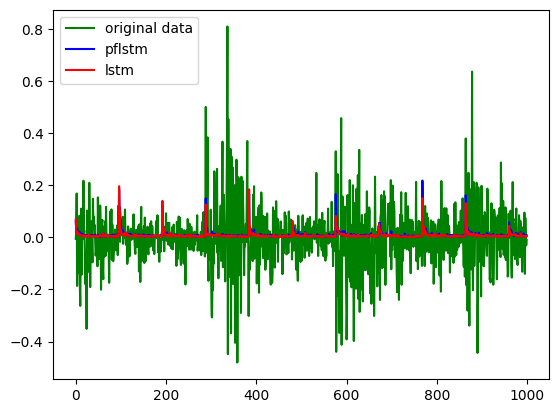

In [ ]:
points_to_include = 1000
plt.plot(train_plot[:points_to_include], c = 'g', label = "original data")
plt.plot(ppnp[:points_to_include], c = 'b', label = "pflstm")
plt.plot(rnnppnp[:points_to_include], c = 'r', label = "lstm")
plt.legend()

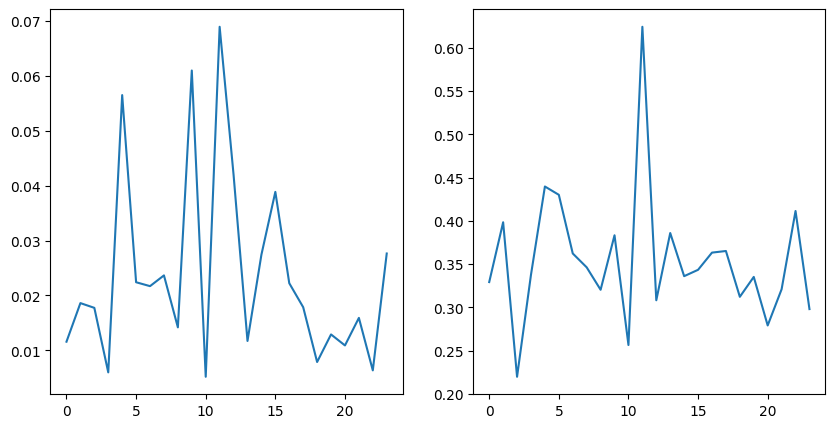

In [ ]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize = (10,5))
for lidx, lnp in enumerate(losses):
    lnp = np.array(lnp)
    ax0.plot(lnp[:,1], label = f"{lidx}_loss")
    ax1.plot(lnp[:,1], label = f"{lidx}_loss_last")

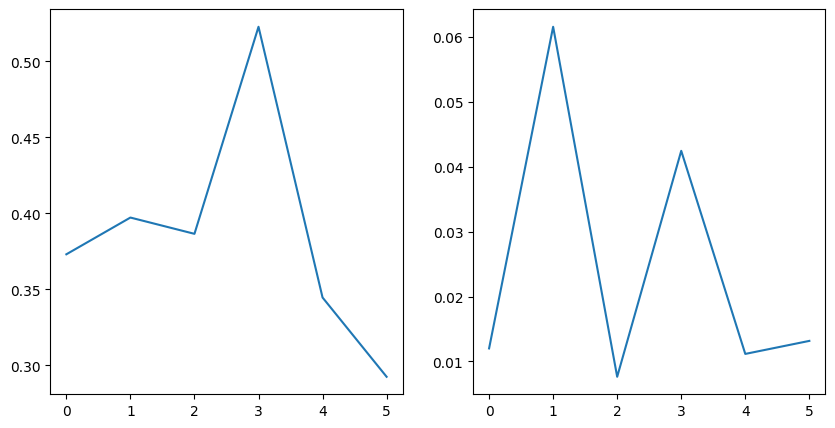

In [ ]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize = (10,5))
for lidx, lnp in enumerate(eval_losses):
    lnp = np.array(lnp)
    ax0.plot(lnp[:,0], label = f"{lidx}_loss")
    ax1.plot(lnp[:,0], label = f"{lidx}_loss_last")